# 获取原始数据

In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.20.88:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata

,timestamp,sqrtPriceX96,price,datetime
0,1620609472,1267554519342589161168659854845874,0.000256,2021-05-10 01:17:52
1,1620609830,1267498129839936824485169221023868,0.000256,2021-05-10 01:23:50
2,1620609889,1267496927736336268048970777338285,0.000256,2021-05-10 01:24:49
3,1620609889,1267496466129159558106023913391909,0.000256,2021-05-10 01:24:49
4,1620609894,1267269382521328460205280017540103,0.000256,2021-05-10 01:24:54
...,...,...,...,...
153322,1636505287,1151304179731807924804200863381341,0.000211,2021-11-10 00:48:07
153323,1636505306,1153213095406308275655367738380110,0.000212,2021-11-10 00:48:26
153324,1636505306,1153226560737155904671591020768514,0.000212,2021-11-10 00:48:26
153325,1636505306,1153227466349991390439811165863993,0.000212,2021-11-10 00:48:26


In [2]:
pricedata['datetime'].tolist()[0]

'2021-05-10 01:17:52'

# 指标计算

In [3]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#之后要扩展回测区间时，需要更新此处的基本行情数据
df_eth = load_obj('../../data/usdceth/symbolsData_2018032120211116_60min_v16_E')['60min']
df_eth.columns= ['open','high','low','close','volume']
df_eth = df_eth.loc['2018-03-22':'2021-11-09']
df_eth.reset_index(inplace=True)
df_eth.columns = ['datetime','open','high','low','close','volume']
def cal_indicator(dataCoin):    
    dataCoin['pctChange'] = dataCoin['close'].pct_change()
    dataCoin['pctStd'] = ta.STDDEV(dataCoin['pctChange'], 24*5)*(24**0.5)
    dataCoin['pctStdVma'] = ta.SUM(dataCoin['pctStd']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['closeVma'] = ta.SUM(dataCoin['close']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['pctStdVSma'] = ta.EMA(dataCoin.pctStdVma, 24*3)
    dataCoin['pctStdVLma'] = ta.MA(dataCoin.pctStdVma, 24*10)
    dataCoin['SmaLowerLma'] = dataCoin['pctStdVSma']<dataCoin['pctStdVLma']
    dataCoin['CloseLowerMA'] = dataCoin['close'] < dataCoin['closeVma']
    #根据volResearch notebook里的BelowMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolLowerBelowmaQuantile50'] = dataCoin['pctStd'] < 0.035857 
    #根据volResearch notebook里的OverMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolHigherOvermaQuantile50Twosigma'] = dataCoin['pctStd'] > (0.038511 + 2*0.018451)
    #当波动率高于Belowma的vol stat中的Quantile50的1.05倍时撤销池子
    dataCoin['revoke_pos'] = dataCoin['pctStd'] > 0.035857 *1.05
    
cal_indicator(df_eth)

df_eth_test_period = df_eth[df_eth['datetime']>parse('2021-05-10 00:00:00+00:00')]
df_signal_tmp = df_eth_test_period[['datetime',
                               'SmaLowerLma',
                               'VolLowerBelowmaQuantile50',
                               'CloseLowerMA',
                               'VolHigherOvermaQuantile50Twosigma',
                               'revoke_pos']]
df_signal_tmp['timestamp'] = [0]*len(df_signal_tmp)
df_signal_tmp['sqrtPriceX96'] = [0]*len(df_signal_tmp)
df_signal_tmp['price'] = [0]*len(df_signal_tmp)

df_signal_tmp = df_signal_tmp[['timestamp','sqrtPriceX96','price','datetime',
                 'SmaLowerLma',
                 'VolLowerBelowmaQuantile50',
                 'CloseLowerMA',
                 'VolHigherOvermaQuantile50Twosigma',
                 'revoke_pos']]
df_signal_tmp['datetime_2'] = df_signal_tmp['datetime']
df_signal_tmp = df_signal_tmp.set_index('datetime_2')
# df_signal_tmp = df_signal_tmp.resample('D').first()
df_signal_tmp['datetime'] = [str(tmp)[:-6] for tmp in df_signal_tmp['datetime'].tolist()]
df_signal_tmp['ind'] = [i for i in range(len(pricedata),len(pricedata)+len(df_signal_tmp))]
df_signal_tmp.set_index('ind',inplace=True)
pricedata_tmp = pricedata.append(df_signal_tmp)
pricedata_tmp = pricedata_tmp.sort_values(by='datetime')
pricedata_tmp_beforefill = pricedata_tmp.copy(deep = True)
pricedata_tmp = pricedata_tmp.fillna(method = 'ffill')
pricedata_res = pricedata_tmp.loc[pricedata.index]
pricedata_res.set_index('datetime',inplace=True)
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos
datetime,,,,,,,,
2021-05-10 01:17:52,1620609472,1267554519342589161168659854845874,0.000256,False,False,False,False,True
2021-05-10 01:23:50,1620609830,1267498129839936824485169221023868,0.000256,False,False,False,False,True
2021-05-10 01:24:49,1620609889,1267496927736336268048970777338285,0.000256,False,False,False,False,True
2021-05-10 01:24:49,1620609889,1267496466129159558106023913391909,0.000256,False,False,False,False,True
2021-05-10 01:24:54,1620609894,1267269382521328460205280017540103,0.000256,False,False,False,False,True
...,...,...,...,...,...,...,...,...
2021-11-10 00:48:07,1636505287,1151304179731807924804200863381341,0.000211,True,True,False,False,False
2021-11-10 00:48:26,1636505306,1153213095406308275655367738380110,0.000212,True,True,False,False,False
2021-11-10 00:48:26,1636505306,1153226560737155904671591020768514,0.000212,True,True,False,False,False


# 回测

In [4]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.0002559611947100053


# 建池撤池详细信息

In [5]:
import Strategy_usdceth_vol_v2
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_usdceth_vol_v2)
strategy = Strategy_usdceth_vol_v2.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000000.0 amount1:  193767622941744726016
price:  0.0003524863942496469
$$$$$$$【Upper Price】: 0.000454528215930865
$$$$$$$【Lower Price】: 0.00027335301478845
######【L】:71725449612659512【USDC】:449725000000【ETH】:163855038906967031808
将要投入池子的数量 amount_t0: 449724999999 amount_t1: 163855038906967031808
【RealWorldTime】:2021-06-03 16:50:54, Timestamp: 1622710254, Blocknumber: 12560564
Mint position： Position(L=71647907245445792, tick=[194220, 199320], range=[2208.3870, 3677.5136])
【Mint amount】: token0=449724.999999, token1=163.50654018568494
Wallet amount: token0=1e-06, token1=30.261082756059793
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: True, VolHigherQuantile50TwoSigma: False
Price(0.00034722516869073754) out of range(0.00027335301478845, 0.000454528215930865)
【RealWorldTime】:2021-06-

******************************************【撤销池子】【原因:超边撤池】******************************************
Price(0.00023687755809824676) out of range(0.00023691879753092322, 0.0003939458229335996)
【RealWorldTime】:2021-10-21 09:17:51,Timestamp: 1634779071, Blocknumber: 13458004
Decreased position： Position(L=0, tick=[192840, 197880], range=[2550.4127, 4221.6666])
【Decreased amount】: token0=1082070.690174, token1=0.22100991850725196
Wallet amount: token0=1082250.963918, token1=40.70129724527442
撤池后经转换 Wallet amount: token0=1249863.53127, token1=2.0429270068239376
**********************【Price Over MA】【创建Long Vol池子】【第10次建池】***********************************
转换后钱包中余额 amount0:  562094876601.0 amount1:  164770024326749713752
price:  0.00023650016554420302
$$$$$$$【Upper Price】: 0.0003049649576999765
$$$$$$$【Lower Price】: 0.00018340575495713664
######【L】:72587981535313760【USDC】:562094876601【ETH】:134308067103111233536
将要投入池子的数量 amount_t0: 562094876601 amount_t1: 134308067103111233536
【RealWorldTime】:2

# 获取原始绩效

In [6]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x1ec4d299f28>,
 2: <univ3api.simulation.PositionReport at 0x1ec4d2a5518>,
 3: <univ3api.simulation.PositionReport at 0x1ec4d2ac630>,
 4: <univ3api.simulation.PositionReport at 0x1ec4d2accc0>,
 5: <univ3api.simulation.PositionReport at 0x1ec4d2ac9e8>,
 6: <univ3api.simulation.PositionReport at 0x1ec4d2ace48>,
 7: <univ3api.simulation.PositionReport at 0x1ec4d2ac978>,
 8: <univ3api.simulation.PositionReport at 0x1ec4d931550>,
 9: <univ3api.simulation.PositionReport at 0x1ec52f6acc0>,
 10: <univ3api.simulation.PositionReport at 0x1ec52f6ada0>}

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-07-26 06:56:05,441765.867343,0.000000,0.000000,0.000000,208.957,0.000000,0.000000,0.000000
1,2021-07-26 07:03:40,442015.368765,0.124750,0.124750,0.124750,208.841,0.000000,0.000000,0.000000
2,2021-07-26 07:04:19,442452.758098,0.218694,0.343444,0.343444,208.639,0.000000,0.000000,0.000000
3,2021-07-26 07:04:38,443034.904519,0.291073,0.634517,0.634517,208.37,0.000000,0.000000,0.000000
4,2021-07-26 07:05:54,443286.236870,0.125666,0.760183,0.760183,208.254,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
7855,2021-08-05 22:38:48,944040.045190,0.949280,1755.006298,1755.006298,3.96261,0.000000,0.615338,0.615338
7856,2021-08-05 22:39:57,944800.244846,0.380099,1755.386397,1755.386397,3.68884,0.000000,0.615338,0.615338
7857,2021-08-05 22:40:08,948699.550029,1.949652,1757.336049,1757.336049,2.28609,0.000000,0.615338,0.615338
7858,2021-08-05 22:40:10,949379.591324,0.340020,1757.676069,1757.676069,2.04171,0.000000,0.615338,0.615338


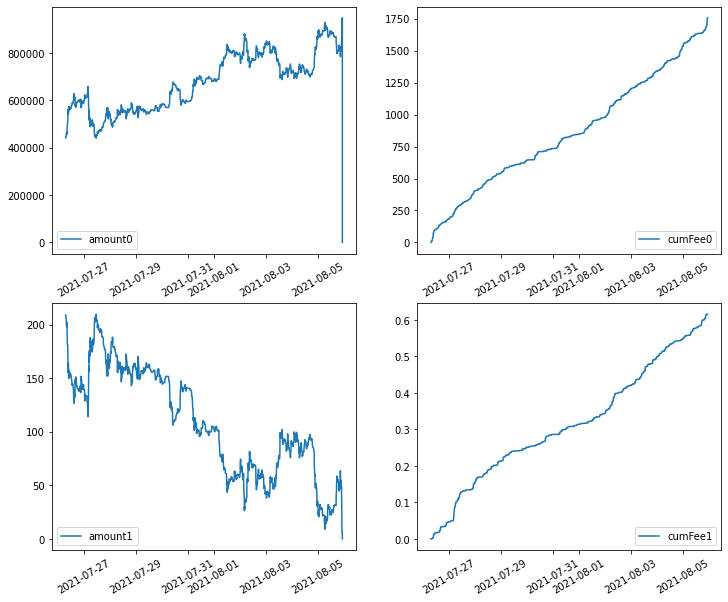

In [7]:
positions[5].get_balance(plain=True, draw_plot=True)

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-06-03 16:50:54,449724.999999,0.000000,0.000000,0.000000,163.507,0.000000e+00,0.000000,0.000000
1,2021-06-03 17:00:10,449226.226061,0.000000,0.000000,0.000000,163.682,8.789403e-05,0.000088,0.000088
2,2021-06-03 17:12:00,450809.434994,0.791604,0.791604,0.791604,163.125,0.000000e+00,0.000088,0.000088
3,2021-06-03 17:12:40,451422.405287,0.306485,1.098089,1.098089,162.909,0.000000e+00,0.000088,0.000088
4,2021-06-03 17:12:43,451988.507055,0.283050,1.381139,1.381139,162.709,0.000000e+00,0.000088,0.000088
5,2021-06-03 17:13:16,453258.238508,0.634865,2.016004,2.016004,162.263,0.000000e+00,0.000088,0.000088
6,2021-06-03 17:13:16,454326.688643,0.534225,2.550229,2.550229,161.887,0.000000e+00,0.000088,0.000088
7,2021-06-03 17:13:35,455097.858449,0.385584,2.935813,2.935813,161.616,0.000000e+00,0.000088,0.000088
8,2021-06-03 17:13:50,456222.790022,0.562465,3.498278,3.498278,161.221,0.000000e+00,0.000088,0.000088
9,2021-06-03 17:15:26,456882.607106,0.329908,3.828186,3.828186,160.989,0.000000e+00,0.000088,0.000088


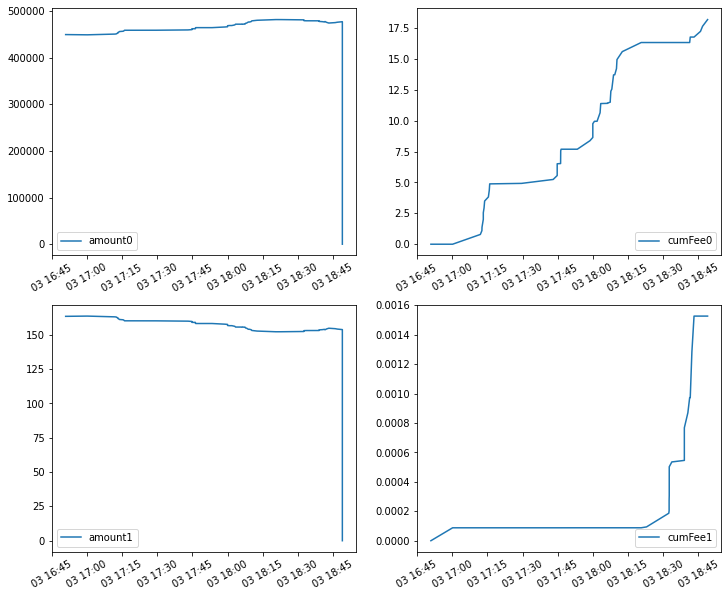

In [8]:
positions[1].get_balance(plain=True, draw_plot=True)

In [9]:
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)

<AxesSubplot:title={'center':'Total Balance'}>

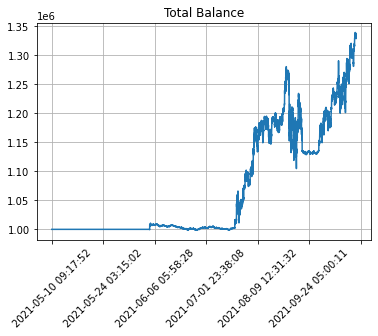

In [10]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True,title='Total Balance')
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

In [11]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620609472,0.000000
1620609830,0.000000
1620609889,0.000000
1620609894,0.000000
1620610623,0.000000
...,...
1636505114,488902.134724
1636505262,489107.001547
1636505287,489116.086885


In [12]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620609472,1000000.000000
1620609830,1000000.000000
1620609889,1000000.000000
1620609894,1000000.000000
1620610623,1000000.000000
...,...
1636505084,843264.896807
1636505114,841553.108255
1636505262,841298.108265


In [13]:
tb_Timing

2021-05-10 09:17:52    1.000000e+06
2021-05-10 09:23:50    1.000000e+06
2021-05-10 09:24:49    1.000000e+06
2021-05-10 09:24:54    1.000000e+06
2021-05-10 09:37:03    1.000000e+06
                           ...     
2021-11-10 08:45:14    1.330455e+06
2021-11-10 08:47:42    1.330405e+06
2021-11-10 08:48:07    1.330403e+06
2021-11-10 08:48:26    1.328775e+06
2021-11-10 08:48:53             NaN
Length: 118264, dtype: float64

# 计算绩效指标

In [14]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    1.000000e+06
2021-05-11    1.000000e+06
2021-05-12    1.000000e+06
2021-05-13    1.000000e+06
2021-05-14    1.000000e+06
                  ...     
2021-11-06    1.288477e+06
2021-11-07    1.314668e+06
2021-11-08    1.332481e+06
2021-11-09    1.336289e+06
2021-11-10    1.328775e+06
Freq: D, Length: 185, dtype: float64

In [15]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb = df_tb.iloc[:-1,:]
df_tb

,close,return,return_2
2021-05-10,1.000000e+06,NaN,NaN
2021-05-11,1.000000e+06,0.000000,0.000000
2021-05-12,1.000000e+06,0.000000,0.000000
2021-05-13,1.000000e+06,0.000000,0.000000
2021-05-14,1.000000e+06,0.000000,0.000000
...,...,...,...
2021-11-05,1.298486e+06,-0.002394,-0.002394
2021-11-06,1.288477e+06,-0.007708,-0.007708
2021-11-07,1.314668e+06,0.020327,0.020327
2021-11-08,1.332481e+06,0.013549,0.013549


<AxesSubplot:>

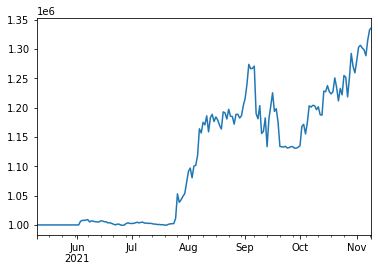

In [16]:
df_tb['close'].plot()

In [17]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


# 输出绩效

【SWAP_USDC_WETH_3000】

USDC手续费 10365.769002 ETH手续费(USDC计价) 13719.837301090993
***************************资金曲线绩效***************************
最大回撤 0.1121737208165886
最长回撤持续期 55 日 起始日期 2021-09-03 00:00:00 结束日期 2021-10-28 00:00:00
年化收益 0.7828417999151238
夏普比率 3.0983433195108296
卡尔玛比率 6.9788342065885605


<AxesSubplot:title={'center':'Total Balance'}>

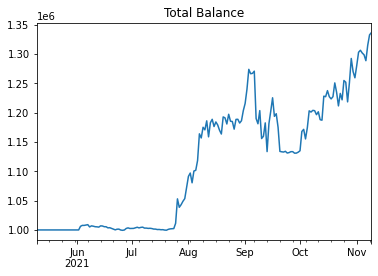

In [18]:
print('【SWAP_USDC_WETH_3000】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('USDC手续费',cumfee0,'ETH手续费(USDC计价)',cumfee1)
print('***************************资金曲线绩效***************************')
print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')

In [20]:
annualReturnNoneStrategy50 = 0.22855581332998387
annualReturnNoneStrategy100 = 0.29521239617921324
annualRetrunStrategy = 0.7828417999151238
print('相对Case_usdceth_none_3000_50per年化',annualRetrunStrategy - annualReturnNoneStrategy50)
print('相对Case_usdceth_none_3000_100per年化',annualRetrunStrategy - annualReturnNoneStrategy100)

相对Case_usdceth_none_3000_50per年化 0.55428598658514
相对Case_usdceth_none_3000_100per年化 0.48762940373591057
